## Init

Imports:

In [1]:
using Pkg
Pkg.activate((@__DIR__)*"/../one_flav_env")

using NaNMath
using QuadGK
using DifferentialEquations
using Interpolations
using Roots
using PythonPlot
using LaTeXStrings
import SpecialFunctions: besselk
import LinearAlgebra: dot
import PhysicalConstants.CODATA2018: G, FineStructureConstant
using NaturallyUnitful

figdir = "./"

golden_ratio = (1+sqrt(5))/2

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")
;

  Activating project at `~/Dropbox (University of Oregon)/MuC/Aria/one_flav/code/one_flav_env`


In [2]:
include((@__DIR__)*"/../one_flav_env/boltz_solve.jl")
using .LFDM_Boltz

Calculate maximum $m_\chi$:

In [13]:
LFDM_Boltz.find_mχ_max()
# result : 3620.641627341033

3620.64130123297

## Boltzmann equation solving with test parameters:

In [3]:
mphi = 1e4
mchi = 1e3
λ = find_λ(mphi, mchi)

M = LFDM(λ, mphi, mchi)
;

In [15]:
x0 = 1e-4
xf = 1e8
z0 = [-log(Y_eq(x0, M.gφ)), 0.0]
y0 = 0.0
xspan = (x0, xf)

# prob = ODEProblem(diffeq, z0, xspan, M)
# # sol = solve(prob, Rodas5P())
# sol = solve(prob, Rodas4P(), reltol=1e-10)

# prob2 = ODEProblem(f_χ, y0, xspan, M)
# sol2 = solve(prob2, AutoTsit5(Rodas5P()))

prob5 = ODEProblem(diffeq_2, z0, log.(xspan), M)
sol5 = solve(prob5, Rodas4P(), reltol=1e-10)

# prob3 = ODEProblem(f_φ, z0[1], xspan, M)
# sol3 = solve(prob3, Rodas5P())

# prob4 = ODEProblem(diffeq_1Z, z0, xspan, M)
# sol4 = solve(prob, Rodas5P())

xrange = 10 .^range(log10(1e-4), log10(xf), 10000)
yeqs = Y_eq.(xrange, M.gφ)

Yφs = zero(xrange)
Yχs = zero(xrange)
Yχ_est = zero(xrange)
# Yφ_Z = zero(xrange)
for (i,x) in enumerate(xrange)
    Yφs[i] = exp(-sol5(log(x))[1])
    Yχs[i] = sol5(log(x))[2]
    # Yχ_est[i] = sol2(x)
    # Yφ_est[i] = exp(-sol3(x))
    # Yφ_Z[i] = exp(-sol4(x)[1])
    # Yχ_Z[i] = sol(x)[2]
end
;

UndefVarError: UndefVarError: `diffeq_2` not defined

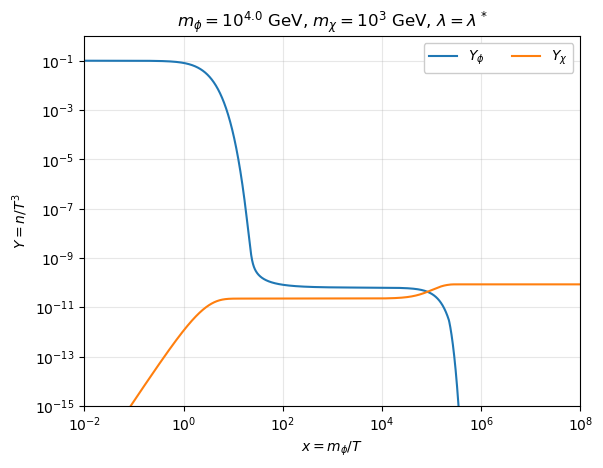

In [14]:
fig1 = figure()

plot(xrange, Yφs, label=L"$Y_\phi$", c="tab:blue")

plot(xrange, Yχs, label=L"$Y_\chi$", c="tab:orange")

# plot(xrange, yeqs, label=L"$Y_{\phi,\textrm{EQ}}$", linestyle="dashed", c="grey")

# plot(xrange, find_yφf(M.mφ)*ones(typeof(xrange[1]), length(xrange)), label=L"Y_\phi^{\textrm{FO}}",
#         linestyle="dashed", c="tab:blue")

# plot(xrange, find_yχf(M.λ, M.mφ, M.mχ)*ones(typeof(xrange[1]), length(xrange)), label=L"Y_\chi^{\textrm{FI}}",
#         linestyle="dashed", c="tab:orange")

xlim(1e-2, 1e8)
ylim(1e-15, 1)

xscale("log")
yscale("log")

grid(alpha=0.3)

# title(L"$\lambda = 10^{%$(log10(M.λ))}$, $m_\phi = 10^{%$(log10(M.mφ))}$ GeV, $m_\chi = 10^{%$(Int(log10(M.mχ)))}$ GeV")
title(L"$m_\phi = 10^{%$(round(log10(M.mφ)))}$ GeV, $m_\chi = 10^{%$(Int(log10(M.mχ)))}$ GeV, $\lambda = \lambda^*$")
xlabel(L"x = m_\phi/T")
ylabel(L"Y = n/T^3")

legend(ncols=2, framealpha=1)
# savefig(figdir * "freezing.pdf")
fig1

## Testing two different $m_\phi$ along the same $\tau_\phi$ and $m_\chi$:

In [3]:
τφ_test = 1e-4
λs_test, mφs_test, mχs_test = find_mφ_τ(τφ_test, 5e2)
Ms = LFDM.(λs_test, mφs_test, mχs_test)
;

In [5]:
sols = solve_boltzmann.(Ms)
xrange = 10 .^range(log10(1e-4), log10(1e8), 10000)

Yφs = zeros(Float64, (length(Ms), length(xrange)))
Yχs = zeros(Float64, (length(Ms), length(xrange)))

for (i, mm) in enumerate(Ms)
    s = sols[i](xrange)
    Yφs[i,:] = s[1,:]
    Yχs[i,:] = s[2,:]
end
;

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/aradick/.julia/packages/SciMLBase/szsYq/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/aradick/.julia/packages/SciMLBase/szsYq/src/integrator_interface.jl:606


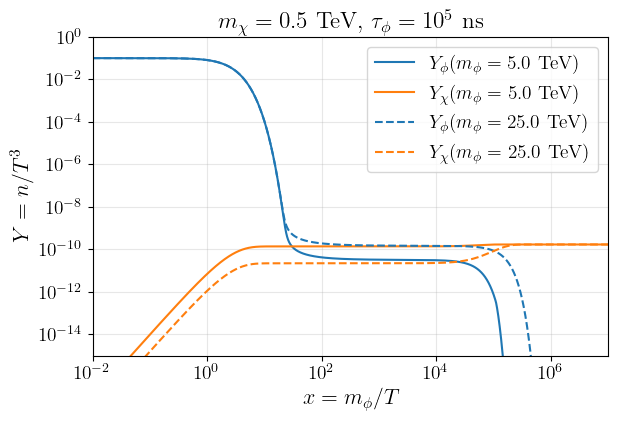

In [6]:
color = ["tab:blue", "tab:orange"]
LS = ["solid", "dashed", "dashdot"]
Labelφ = [L"$Y_\phi(m_\phi = %$(round(1e-3*Ms[1].mφ,sigdigits=2))$ TeV)",
        L"$Y_\phi(m_\phi = %$(round(1e-3*Ms[2].mφ,sigdigits=2))$ TeV)"]
Labelχ = [L"$Y_\chi(m_\phi = %$(round(1e-3*Ms[1].mφ,sigdigits=2))$ TeV)",
        L"$Y_\chi(m_\phi = %$(round(1e-3*Ms[2].mφ,sigdigits=2))$ TeV)"]

fig2 = figure()
xlabel(L"$x = m_\phi / T$")
ylabel(L"$Y = n / T^3$")
title(L"$m_\chi = %$(round(mχs_test[1]*1e-3, sigdigits=2))$ TeV, $\tau_\phi = 10^{%$(round(Int,log10(τφ_test*1e9)))}$ ns")
# xscale("log")
# yscale("log")
for i in range(1, length(Ms))
    plot(NaNMath.log10.(xrange), NaNMath.log10.(Yφs[i,:]), color=color[1], linestyle=LS[i], label=Labelφ[i])
    plot(NaNMath.log10.(xrange), NaNMath.log10.(Yχs[i,:]), color=color[2], linestyle=LS[i], label=Labelχ[i])
end
xlim(-2, 7)
ylim(-15, 0)
grid(alpha=0.3)
legend()

xticks = -2:2:6
yticks = -14:2:0

xticklabels = [L"10^{%$(round(Int,x))}" for x in xticks]
yticklabels = [L"10^{%$(round(Int,x))}" for x in yticks]

ax = gca()
ax.set_aspect((9)/(15*golden_ratio), adjustable="box")

ax.set_xticks(xticks, xticklabels)
ax.set_yticks(yticks, yticklabels)
# plot(xrange, yeqs, color=:grey, linestyle=:dash, label=L"$Y_\phi^{\textrm{EQ}}$")
plotclose()
# fig2.savefig(figdir*"same_mchi_freeze.pdf", bbox_inches="tight")
fig2

## Contours of constant $\lambda$ and constant $\tau_\phi$:

In [7]:
Mphis = 10 .^ range(2, log10(2e4), 1000)
Mchis = 10 .^ range(-5, log10(3.6e3), 1000)

λs = find_λs(Mphis, Mchis)
τs = lifetime.(λs, Mphis, Mchis')

function mχ_upper_bound(mφ)
    min(LFDM_Boltz.Mstar_s(mφ/25)/LFDM_Boltz.find_yφf(mφ), mφ)
end

mχ_upper = mχ_upper_bound.(Mphis)
;

### $\lambda$ contours

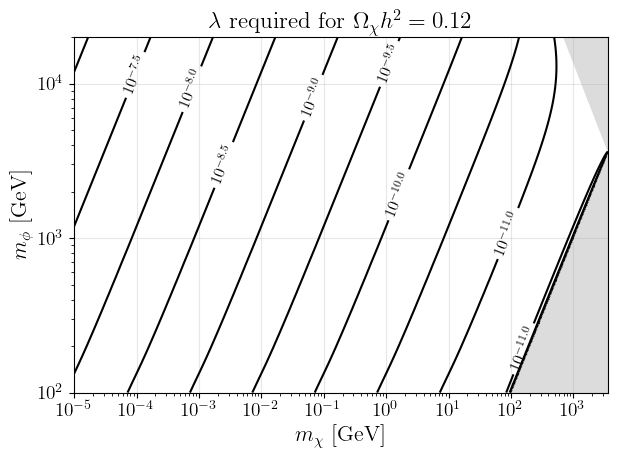

In [8]:
fig3 = figure()

xlim(1e-5, 3.6e3)
ylim(1e2, 2e4)

xscale("log")
yscale("log")

grid(alpha=0.3)

title(L"$\lambda$ required for $\Omega_\chi h^2 = 0.12$")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

levels = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11])
C = contour(Mchis, Mphis, λs, levels=levels, norm="log", colors="k")

formatter(l) = L"10^{ %$(log10(l)) }"

lvs = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -11])

fill_betweenx(Mphis, mχ_upper, 4e3, color="gainsboro")#, alpha=0.2)

clabel(C, lvs[1:end-3], colors="black", fmt=formatter, use_clabeltext=true, 
        inline=true, inline_spacing=5, fontsize=12)#, manual=((3e-5, 5e3), (3e-4, 4e3),
        # (3e-3, 3e3), (3e-2, 3e3), (3e-1, 3e3), (3e0, 3e3), (3e1, 3e2)))

plotclose()
# fig3.savefig(figdir * "lambda_relic.pdf", bbox_inches="tight")
fig3

### $\tau_\phi$ contours

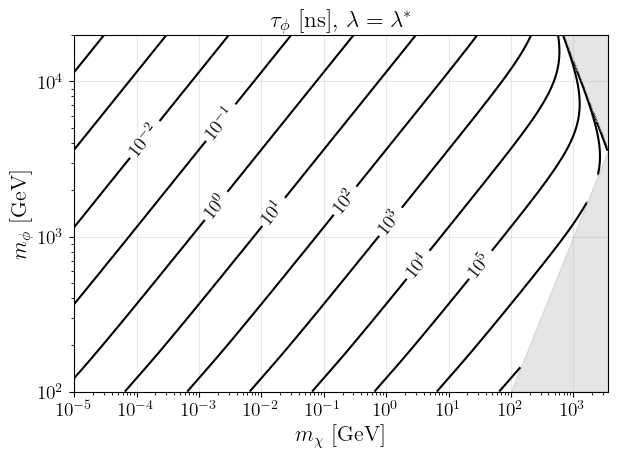

In [9]:
fig4 = figure()

xlim(1e-5, 3.6e3)
ylim(1e2, 2e4)

xscale("log")
yscale("log")

levels = 10.0 .^(-6:8)
C = contour(Mchis, Mphis, τs .* 1e9, levels=levels, norm="log", colors="black")

formatter(l) = L"10^{ %$(Int(log10(l))) }"

clabel(C, levels[5:end-3], colors="black", fmt=formatter, use_clabeltext=true, 
        inline=true)

fill_betweenx(Mphis, mχ_upper, 6e3, color="grey", alpha=0.2)

# plot(mχ_prompt, Mphis_life)

grid(alpha=0.3)

title(L"$\tau_\phi$ [ns], $\lambda = \lambda^*$")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

plotclose()
# fig4.savefig(figdir * "phi_lifetime.pdf")
fig4

### smuon (displaced) and stau ($dE / dx$) bounds overlaid

In [10]:
Mphis_life = 10 .^ range(2, log10(2e4), 100)
mχ_prompt = mχ_life.(3e-11, Mphis_life)
;

In [11]:
import DelimitedFiles: readdlm
seR_dir = "../data/selectron_bounds/"

se_lo_data = readdlm(seR_dir * "seR_bounds_lower.csv", ',')
se_hi_data = readdlm(seR_dir * "seR_bounds_upper.csv", ',')

se_lo_func = linear_interpolation(se_lo_data[:,1], se_lo_data[:,2] .* 1e-9, extrapolation_bc=Line())
se_hi_func = linear_interpolation(se_hi_data[:,1], se_hi_data[:,2] .* 1e-9, extrapolation_bc=Line())

seR_mphis = 10 .^ range(2, log10(584), 100)

seR_lo_mχ = mχ_life.(se_lo_func.(seR_mphis), seR_mphis)
seR_hi_mχ = mχ_life.(se_hi_func.(seR_mphis), seR_mphis)
;

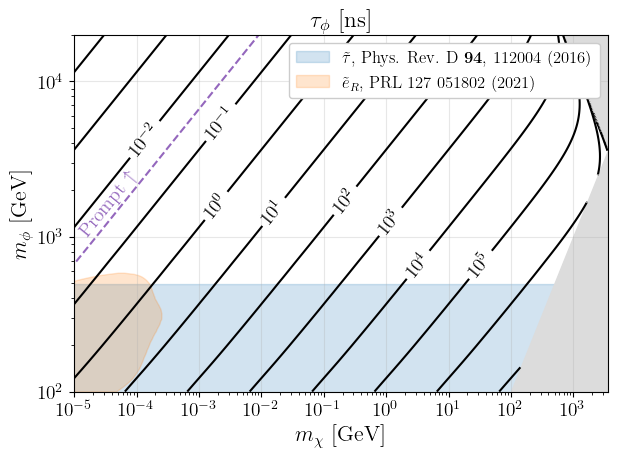

In [12]:
fig6 = figure()

xlim(1e-5, 3.6e3)
ylim(1e2, 2e4)

xscale("log")
yscale("log")

levels = 10.0 .^(-6:8)
C = contour(Mchis, Mphis, τs .* 1e9, levels=levels, norm="log", colors="black")

formatter(l) = L"10^{ %$(Int(log10(l))) }"

clabel(C, levels[5:end-3], colors="black", fmt=formatter, use_clabeltext=true, inline=true)

fill_between(Mchis, 0, 490, color="tab:blue", alpha=0.2, label=L"$\tilde{\tau}$, Phys. Rev. D \textbf{94}, 112004 (2016)")
fill_betweenx(seR_mphis, seR_lo_mχ, seR_hi_mχ, color="tab:orange", alpha=0.2, label=L"$\tilde{e}_R$, PRL 127 051802 (2021)")
fill_betweenx(Mphis, mχ_upper, 1e4, color="gainsboro")#, alpha=0.2)

plot(mχ_prompt, Mphis_life, c="tab:purple", linestyle="dashed")

text(1.1e-5, 1e3, L"Prompt $\uparrow$", rotation=51, c="tab:purple")

grid(alpha=0.3)

title(L"$\tau_\phi$ [ns]")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

legend(fontsize=12, framealpha=1)

plotclose()
# fig6.savefig(figdir * "current_bounds.pdf")
fig6

# Bonus: Comparing $\lambda$ calculations

In [22]:
Mphis_test = 10 .^ range(2, log10(2e4), 10)
Mchis_test = 10 .^ range(-5, 3, 10)

λs = find_λs(Mphis_test, Mchis_test)
λs_full = LFDM_Boltz.find_λs_full(Mphis_test, Mchis_test)

rel_err = abs.((λs_full .- λs) ./ λs_full)
;

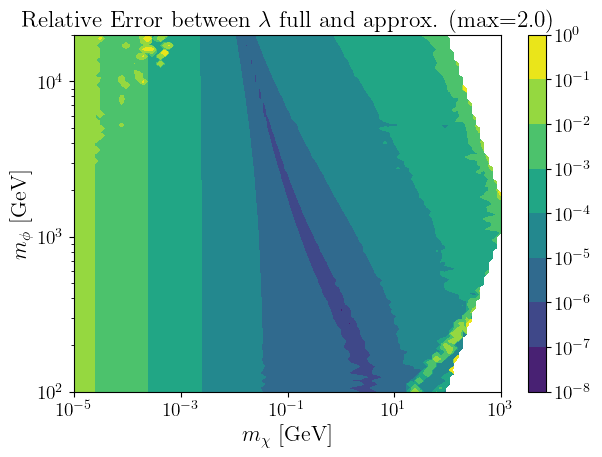

In [13]:
f17 = figure()
# pcm = pcolormesh(10 .^Mchis_test_log, 10 .^Mphis_test_log, rel_err, norm="log",
#             vmax=1, vmin=1e-6)
c = contourf(Mchis_test, Mphis_test, rel_err, levels=(10 .^ (-8.0:0.0)), norm="log")
xscale("log")
yscale("log")
title(L"Relative Error between $\lambda$ full and approx. (max=%$(round(maximum(filter(!isnan,rel_err)), sigdigits=3)))")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")
xlim(1e-5, 1e3)
colorbar(c)
plotclose()
# f17.savefig(figdir*"lambda_rel_err.pdf")
f17